In [1]:
import os
import numpy as np 
np.random.seed(7)

import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import copy 
import pandas as pd
import time
import datetime

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tslearn.clustering import TimeSeriesKMeans


# Preprocessing


In [2]:
#For scaling all the houses at once
# Dataset = r'../15minute_data_newyork/15minute_data_newyork.csv'
# fulldata = pd.read_csv(Dataset) 
# data=fulldata[['dataid','local_15min','grid']]
# scaler = MinMaxScaler(feature_range=(0, 1))

# dataset = np.matrix(data['grid'].values).transpose()
# dataset = dataset.astype('float32')
# dataset = scaler.fit_transform(dataset)
# data['grid'] = pd.Series(dataset.flatten())

In [3]:
Dataset = r'../15minute_data_newyork/15minute_data_newyork.csv'
fulldata = pd.read_csv(Dataset) 
data=fulldata[['dataid','local_15min','grid']]
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])
ids=sorteddata['dataid'].unique().tolist()
housing_data = []
housing_data_numpy = []
def convertDate(d):
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    # housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for faster ploting 
    # housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)


In [4]:
def create_dataset(dataset, look_back=1, look_ahead=None):
	"function for creating dataset for model, X being the known data, and Y being target data"
	if look_ahead is None:
		look_ahead = look_back
	dataX, dataY = [], []
	for i in range(len(dataset)-2*look_back):
		dataX.append(dataset[i:(i+look_back), 0])
		if look_ahead == 0:
			dataY.append(dataset[i + look_back, 0])
		else:
			dataY.append(dataset[(i+look_back):(i+look_back+look_ahead), 0])
		
	return np.array(dataX), np.array(dataY)

In [5]:
#one house case
# dataframe = pd.concat([housing_data[0]['grid'], housing_data[1]['grid']]) 
# for i in range(2, len(ids)):
#     dataframe = pd.concat([dataframe,housing_data[i]['grid'] ])
# dataset = np.matrix(dataframe.values).transpose()
# dataset = dataset.astype('float32')    
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

In [6]:
def dataset_per_house(house, look_back = 96):
    dataframe = house['grid']
    dataset = np.matrix(dataframe.values).transpose()
    dataset = dataset.astype('float32')

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    print(len(dataset))
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:,:]
    # look_back = 96 #(60mins/15min)*24 hours
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    return trainX, trainY, testX, testY, dataset, scaler

In [7]:
def get_avg_day(look_back =96,  house = 0, absolute = False):

    dataframe = housing_data[house]['grid']
    fulldays=len(dataframe)//look_back
    grid_data=dataframe.to_numpy()

    grid_day_matrix=grid_data[:(look_back*fulldays)].reshape(-1, look_back)
    if absolute == True:
        grid_day_matrix = abs(grid_day_matrix)
    #avg house0 grid data 
    avg_house_grid=np.mean(grid_day_matrix, axis=0)
    # print(grid_day_matrix.shape)
    return avg_house_grid

def get_avg_day_from_predict(data, look_back =96, absolute = False):
    grid_day_matrix= data[::look_back]
    if absolute == True:
        grid_day_matrix = abs(grid_day_matrix)
    #avg house0 grid data 
    avg_house_grid=np.mean(grid_day_matrix, axis=0)
    return avg_house_grid

In [8]:
avg_house_list = []
for i in range(len(housing_data)):
    avg_house_list.append(get_avg_day(house= i))
np_avg_house = np.asarray(avg_house_list) 
r,c =np_avg_house.shape
np_avg_house_3d = np.reshape(np_avg_house,(r,c,1))

In [9]:
np_avg_house.shape

(25, 96)

In [10]:
KMmodel=TimeSeriesKMeans.from_hdf5('../models/KM/KM1.h5')

In [11]:
houseclasses= KMmodel.fit_predict(np_avg_house_3d)

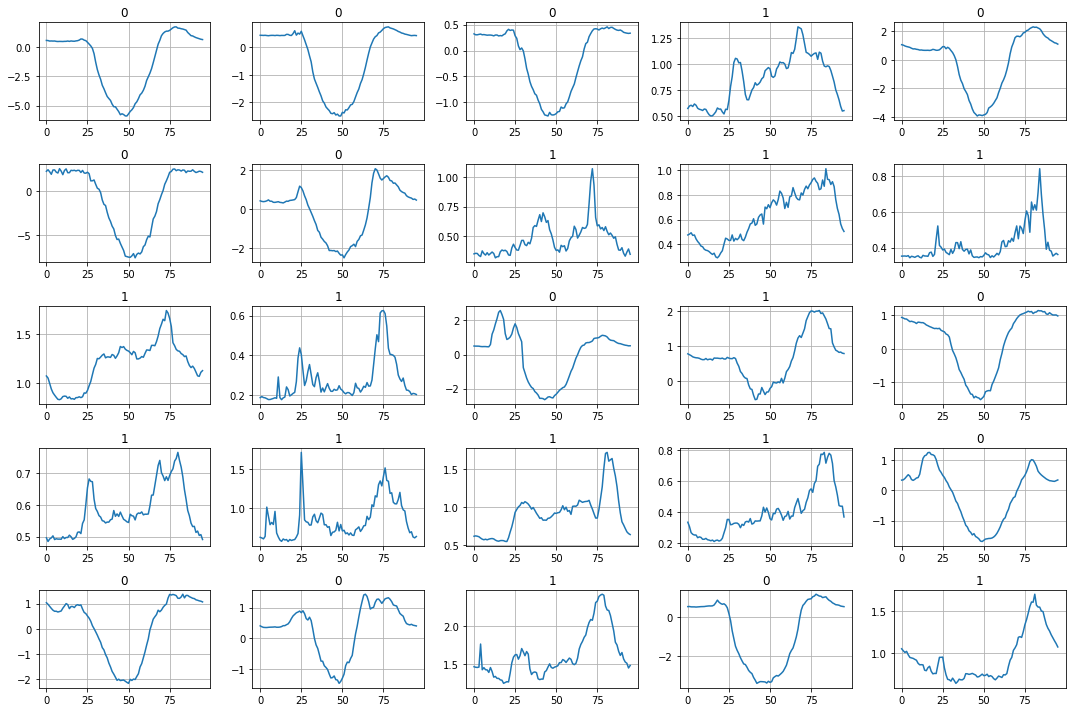

In [12]:
plt.figure(figsize=(15, 10))
for i in range(len(avg_house_list)):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,5,i+1) 
    plt.plot(avg_house_list[i])
    plt.title(f'{houseclasses[i]}')
    plt.grid(True)
plt.tight_layout()

In [13]:
solarhouses0 = []
nonsolarhouses1 = []
for i, classes in enumerate(houseclasses): 
    if classes==0:
        solarhouses0.append(housing_data[i])
    else: 
        nonsolarhouses1.append(housing_data[i])

numofsolarhouses = len(solarhouses0)
numofnonsolarhouses = len(nonsolarhouses1)

In [14]:
numbertrainingsolarhouse=int(numofsolarhouses * 2/3)
numbertraininghouse=int(numofnonsolarhouses * 2/3)

In [15]:
listoftrainXsolar = []
listoftrainYsolar =[]
listoftestXsolar = []
listoftestYsolar = []
listofdatasetsolar = []
listofscalersolar = []
for i in range(numbertrainingsolarhouse ):
    trainX, trainY, testX, testY, dataset, scaler =dataset_per_house(solarhouses0[i])
    listoftrainXsolar.append(trainX)
    listoftrainYsolar.append(trainY)
    listoftestXsolar.append(testX)
    listoftestYsolar.append(testY)
    listofdatasetsolar.append(dataset)
    listofscalersolar.append(scaler)



In [16]:
#get val data

listofvaltrainXsolar = []
listofvaltrainYsolar =[]
listofvaltestXsolar = []
listofvaltestYsolar = []
listofvaldatasetsolar = []
# listofvalscalersolar = []
for i in range(numbertrainingsolarhouse, numofsolarhouses):
    trainX, trainY, testX, testY, dataset, scaler=dataset_per_house(solarhouses0[i])
    listofvaltrainXsolar.append(trainX)
    listofvaltrainYsolar.append(trainY)
    listofvaltestXsolar.append(testX)
    listofvaltestYsolar.append(testY)
    listofvaldatasetsolar.append(dataset)
    listofscalersolar.append(scaler)

In [17]:
trainY.shape
# len(listofscalersolar)

(11642, 96)

In [18]:
def reshape_stack_reshapeX(X): 
    r,c,z=X[0].shape
    x0 = X[0].reshape(r,c)
    for i, x in enumerate(X):
        if i == 0:
            continue
        r,c,z = x.shape 
        x = x.reshape(r,c)

        x0 = np.vstack((x0,x))
    # print(x0.shape)
    r,c= x0.shape
    x0 = x0.reshape(r,c,1)
    return x0

def reshape_stack_reshapeY(Y, starting_point = 0):     
    y0 = Y[0]
    # print(y0.shape)
    scaler_mapper = (np.zeros(y0.shape) + starting_point)
    for i, y in enumerate(Y):
        if i == 0:
            continue
        scaler_mapper_next = (i*np.ones(y.shape) + starting_point)
        scaler_mapper = np.vstack((scaler_mapper,scaler_mapper_next))
        y0 = np.vstack((y0,y))
    # r,c,= y0.shape
    # y0 = y0.reshape(r,c)
    # print(y0.shape)
    return y0, scaler_mapper

def reshape_stack_reshapedata(data):
    
    r,c = data[0].shape
    # print()
    data0 = data[0].reshape(r)
    # scaler_mapper = [(np.zeros(data0.shape) + starting_point).flatten()]
    for i, points in enumerate(data):
        if i == 0:
            continue
        # points = points.flatten()
        r,c = points.shape
        points = points.reshape(r)
        # scaler_mapper.append((i*np.ones(points.shape) + starting_point).flatten())
        data0 = np.hstack((data0,points))
    # # r, = data0.shape
    # print(data0.shape)
    # data0 = data0.reshape(r,1)
    data0 = data0.transpose()
    # print(data0.shape)
    
    return data0
trainXsolar = reshape_stack_reshapeX(listoftrainXsolar)
trainYsolar, train_scaler_mapper = reshape_stack_reshapeY(listoftrainYsolar)
testXsolar = reshape_stack_reshapeX(listoftestXsolar)
testYsolar, test_scaler_mapper = reshape_stack_reshapeY(listoftestYsolar)
datasetsolar  = reshape_stack_reshapedata(listofdatasetsolar)

valtrainXsolar = reshape_stack_reshapeX(listofvaltrainXsolar)
valtrainYsolar, valtrain_scaler_mapper = reshape_stack_reshapeY(listofvaltrainYsolar, train_scaler_mapper[-1][0]+1)
valtestXsolar = reshape_stack_reshapeX(listofvaltestXsolar)
valtestYsolar, valtest_scaler_mapper = reshape_stack_reshapeY(listofvaltestYsolar, test_scaler_mapper[-1][0]+1)
valdatasetsolar = reshape_stack_reshapedata(listofvaldatasetsolar)



In [19]:
datasetsolar.shape

(141311,)

In [20]:
# valscaler_mapper.shape
# print(train_scaler_mapper.shape)
# print(train_scaler_mapper.shape)

In [21]:
# scaler_mapper[-1][0]

# LSTM

In [22]:
# create and fit the LSTM network
opm = 'adam'
look_back = 96
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, 1))) #32
model.add(Dropout(0.3)) #.2
model.add(Dense(look_back))
model.compile(loss='mean_squared_error', optimizer=opm , metrics=['RootMeanSquaredError'] )
model_mdata = model.fit(trainXsolar, trainYsolar, epochs=3, batch_size=1, verbose=1, shuffle=True, use_multiprocessing=True, validation_data = (valtrainXsolar,valtrainYsolar ))
scores = model.evaluate(testXsolar, testYsolar)
# print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/3
93136/93136 [==============================] - 3116s 33ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 2/3
93136/93136 [==============================] - 3148s 34ms/step - loss: 0.0109 - root_mean_squared_error: 0.1045 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1056
Epoch 3/3
1410/1410 [==============================] - 20s 14ms/step - loss: 0.0109 - root_mean_squared_error: 0.1043


In [23]:
print(f"Avg Losses: {scores}" )

Avg Losses: [0.010877463035285473, 0.10429509729146957]


In [24]:
scores

[0.010877463035285473, 0.10429509729146957]

In [25]:
model_mdata.history

{'loss': [0.012330553494393826, 0.010926680639386177, 0.010663076303899288],
 'root_mean_squared_error': [0.11104314029216766,
  0.10453081876039505,
  0.10326243191957474],
 'val_loss': [0.01149526983499527, 0.011144116520881653, 0.011228847317397594],
 'val_root_mean_squared_error': [0.1072157695889473,
  0.10556541383266449,
  0.10596625506877899]}

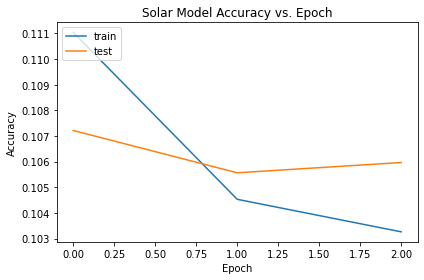

In [26]:
# plt.plot(model_mdata.history['root_mean_squared_error'])
# plt.plot(model_mdata.history['val_root_mean_squared_error'])
# plt.title('Solar Model Accuracy vs. Epoch')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.tight_layout()
# plt.show()

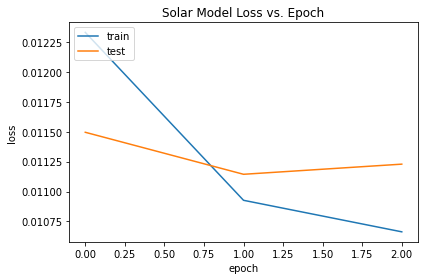

In [27]:
# plt.plot(model_mdata.history['loss'])
# plt.plot(model_mdata.history['val_loss'])
# plt.title('Solar Model Loss vs. Epoch')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.tight_layout()
# # plt.show()

In [28]:
trainPredictsolar = model.predict(trainXsolar)
testPredictsolar = model.predict(testXsolar)

In [29]:
trainPredictsolar[0].shape

(96,)

In [30]:
def unscale_per_house(listofscales, scalemap, data, lookback = 96):
    # print(data.shape)
    unscaled_data = []
    for i,row in enumerate(scalemap):
        # print(i)
        # print(row[-1])
        # if i in [1,2,3,4,5]:
        #     print(data[i].shape)
        unscaled_data.append(listofscales[int(row[0])].inverse_transform(data[i].reshape(1, -1)).reshape(lookback,))
    unscaled_data = np.array(unscaled_data)
    # print(unscaled_data.shape)
    return unscaled_data
# trainPredictsolar = unscale_per_house(listofscalersolar,train_scaler_mapper, trainPredictsolar)

In [31]:
# invert predictions
# scaler = MinMaxScaler(feature_range=(0, 1))
# trainPredictsolar = scaler.inverse_transform(trainPredictsolar)
# trainYsolar = scaler.inverse_transform(trainYsolar)
# testPredictsolar = scaler.inverse_transform(testPredictsolar)
# testYsolar = scaler.inverse_transform(testYsolar)

trainPredictsolar = unscale_per_house(listofscalersolar,train_scaler_mapper, trainPredictsolar)

trainYsolar = unscale_per_house(listofscalersolar,train_scaler_mapper, trainYsolar )

testPredictsolar = unscale_per_house(listofscalersolar,test_scaler_mapper, testPredictsolar )

testYsolar = unscale_per_house(listofscalersolar,test_scaler_mapper, testYsolar )

In [32]:
print(trainPredictsolar.shape)
print(trainYsolar.shape)

(93136, 96)
(93136, 96)


In [33]:
trainScore = math.sqrt(mean_squared_error(trainYsolar[0], trainPredictsolar[0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYsolar[0], testPredictsolar[0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.12 RMSE
Test Score: 1.65 RMSE


In [34]:
trainScore = math.sqrt(mean_squared_error(trainYsolar, trainPredictsolar))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYsolar, testPredictsolar))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.74 RMSE
Test Score: 1.87 RMSE


## Val


In [35]:
valtrainPredictsolar = model.predict(valtrainXsolar)
valtestPredictsolar = model.predict(valtestXsolar)

In [36]:
# valtrainPredictsolar = scaler.inverse_transform(valtrainPredictsolar)
# valtrainYsolar = scaler.inverse_transform(valtrainYsolar)
# valtestPredictsolar = scaler.inverse_transform(valtestPredictsolar)
# valtestYsolar = scaler.inverse_transform(valtestYsolar)


valtrainPredictsolar = unscale_per_house(listofscalersolar,valtrain_scaler_mapper, valtrainPredictsolar)

valtrainYsolar = unscale_per_house(listofscalersolar,valtrain_scaler_mapper, valtrainYsolar)

valtestPredictsolar = unscale_per_house(listofscalersolar,valtest_scaler_mapper, valtestPredictsolar)

valtestYsolar = unscale_per_house(listofscalersolar,valtest_scaler_mapper, valtestYsolar)

In [37]:
trainScore = math.sqrt(mean_squared_error(valtrainYsolar[0], valtrainPredictsolar[0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(valtestYsolar[0], valtestPredictsolar[0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.85 RMSE
Test Score: 0.69 RMSE


In [38]:
trainScore = math.sqrt(mean_squared_error(valtrainYsolar, valtrainPredictsolar))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(valtestYsolar, valtestPredictsolar))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.40 RMSE
Test Score: 1.51 RMSE


In [39]:
testscore = ('%.2f' % (testScore)).replace('.', '_')
# testscore = 'untested'
model.save(f'../models/LSTM_Solar/solar_house_model_{testscore}_{opm}.h5')

In [42]:
avgdayofh23=get_avg_day(house=23)

trainX, trainY, testX, testY, dataset, scaler = dataset_per_house(solarhouses0[-1])
dataset23 = np.reshape(dataset, (dataset.shape[0], dataset.shape[1], 1))
h23_pred = model.predict(dataset23)
h23_pred = scaler.inverse_transform(h23_pred)
avgdayofh23_pred = get_avg_day_from_predict(h23_pred)

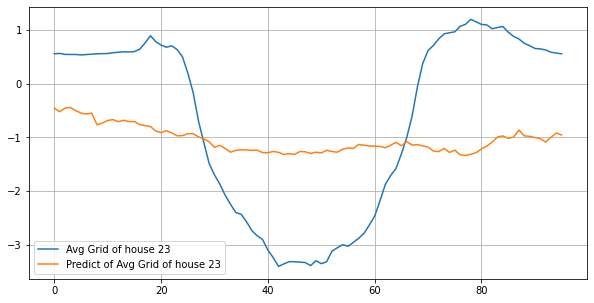

In [43]:
plt.figure(figsize=(10,5))
plt.plot(avgdayofh23, label= 'Avg Grid of house 23' )
plt.plot(avgdayofh23_pred, label = 'Predict of Avg Grid of house 23')
plt.grid(True)
plt.legend()